# Imports and Read-ins

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
import re
import statsmodels.stats.proportion as sprop

In [146]:
members = pd.read_csv('data/NSS_GreatCare_Members.csv')
admissions = pd.read_csv('data/NSS_Hospital_Inpatient_Admissions.csv')
pcp = pd.read_csv('data/NSS_PrimaryCare_Office_Visits.csv')

C:\Users\jrior\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,5,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Getting the House in Order

### Two functions: pvl to append p-values and whether row is significant, only_significant to filter to only significant rows

In [147]:
def pvl(x, nobs, count, null_hyp, kind = 'two-sided', alpha = 0.1):
     def p(y):
        return sprop.proportions_ztest(nobs = y[nobs],
                                   count = y[count],
                                   value = null_hyp,
                                   alternative = kind,
                                   prop_var = null_hyp)[1]
                 
     x['pval'] = x.apply(p, axis = 1)
     x['significant'] = x['pval'] < alpha
    
     return x

def only_significant(x, nobs, count, null_hyp, kind, alpha):
     def p(y):
        return sprop.proportions_ztest(nobs = y[nobs],
                                   count = y[count],
                                   value = null_hyp,
                                   alternative = kind,
                                   prop_var = null_hyp)[1]
                 
     x['pval'] = x.apply(p, axis = 1)
     x['significant'] = x['pval'] < alpha
    
     x2 = x[x['significant'] == True]
    
     return x2    

### Convert date columns to datetime dtype, NPI columns to categories

In [148]:
members['Patient Date of Birth'] = pd.to_datetime(members['Patient Date of Birth'], format='%Y-%m-%d')
members['Period Start Date'] = pd.to_datetime(members['Period Start Date'], format='%Y-%m-%d')
members['Period End Date'] = pd.to_datetime(members['Period End Date'], format='%Y-%m-%d')
members['Empirically Attributed PCP Individual Provider NPI'] = (members['Empirically Attributed PCP Individual Provider NPI']
                                                                .astype("string")
                                                                #.str.replace(".0","")
                                                                .astype("category"))
members['Empirically Attributed PCP Group Provider NPI'] = (members['Empirically Attributed PCP Group Provider NPI']
                                                                .astype("string")
                                                                #.str.replace(".0","")
                                                                .astype("category"))

In [149]:
admissions['Encounter Start Date'] = pd.to_datetime(admissions['Encounter Start Date'], format='%Y-%m-%d')
admissions['Encounter End Date'] = pd.to_datetime(admissions['Encounter End Date'], format='%Y-%m-%d')
admissions['Facility Provider NPI'] = (admissions['Facility Provider NPI'].astype("string")
                                       #.str.replace(".0","")
                                       .astype("category"))
admissions['Attending Provider NPI'] = (admissions['Attending Provider NPI'].astype("string")
                                        .str.replace("\.0","")
                                        .astype("category"))

<ipython-input-149-ea8517b1416f>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  admissions['Attending Provider NPI'] = (admissions['Attending Provider NPI'].astype("string")


In [150]:
pcp['Encounter Date'] = pd.to_datetime(pcp['Encounter Date'], format='%Y-%m-%d')
pcp['Service Provider NPI'] = (pcp['Service Provider NPI']
                               .astype("string")
                               .str.replace("\.0","")
                               .astype("category"))
pcp['Provider Group NPI'] = (pcp['Provider Group NPI']
                             .astype("string")
                             .str.replace("\.0","")
                             .astype("category"))

<ipython-input-150-054b4ec1f3ba>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  pcp['Service Provider NPI'] = (pcp['Service Provider NPI']
<ipython-input-150-054b4ec1f3ba>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  pcp['Provider Group NPI'] = (pcp['Provider Group NPI']


### Take select columns from the dataframes

In [151]:
memb = members[['Patient ID', 'Primary Plan ID', 'Patient Age Integer', 'Patient Date of Birth', 'Patient ZIP Code 5-Digit',
       'Empirically Attributed PCP Individual Provider NPI',
       'Empirically Attributed PCP Individual Provider Description',
       'Empirically Attributed PCP Group Provider NPI',
       'Empirically Attributed PCP Group Provider Description']]

In [152]:
adm = admissions[['Encounter ID', 'Patient ID', 'Attending Provider NPI',
       'Facility Provider NPI', 'Encounter Start Date', 'Encounter End Date',
       'Principal Discharge Diagnosis ICD-9-CM Code',
       'Principal Discharge Diagnosis ICD-9-CM Description',
       'Principal Discharge Diagnosis ICD-10-CM Code',
       'Principal Discharge Diagnosis ICD-10-CM Description',
       'Primary Plan Allowed Amount', 'Primary Plan Paid Amount',
       'Patient Paid Amount']]

In [153]:
#reduce pcp to relevant columns
pc = pcp[['Encounter ID','Patient ID', 'Attending Provider NPI', 'Service Provider NPI',
          'Provider Group NPI','Encounter Date']]                                                                     

# Problem 1: 30-day Readmission Rate

## Preparation: create Patient Adm Count

In [154]:
#count how many visits each patient has had up to and including current visit
adm['Patient Adm Count'] = adm.groupby('Patient ID')['Encounter Start Date'].transform('rank', method = 'first')

<ipython-input-154-e07c32f388a7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adm['Patient Adm Count'] = adm.groupby('Patient ID')['Encounter Start Date'].transform('rank', method = 'first')


## Self-join on Patient ID and Patient Adm Count

In [155]:
#Create new dataframe from admissions that only has three columns
readmits = adm[['Patient ID', 'Patient Adm Count', 'Encounter Start Date']]

#Add 1 to all patient_adm_ct. This transformation allows us to put the discharge date from the patient's previous hospital
#visit on the same line as their current visit, thus allowing us to calculate a difference in dates.
readmits['Patient Adm Count'] -= 1

#merge the two dataframes on patient id and the transformed patient_adm_ct
readmissions = pd.merge(adm, readmits, how = 'left', on = ['Patient ID', 'Patient Adm Count'], suffixes = ('', ' Next'))

#calculate the days of difference between next encounter's start date and the current encounter's end date
readmissions['Days Until Readmission'] = readmissions['Encounter Start Date Next'] - readmissions['Encounter End Date']

#create boolean 'Under 30 Days'
readmissions['Under 30 Days'] = (readmissions['Days Until Readmission'] >= dt.timedelta(days = 0)) & (readmissions['Days Until Readmission'] <= dt.timedelta(days = 30))

#Get 30-day readmission rate
#First pass at under-30-day rate.
under_30_d_rate = sum(readmissions['Under 30 Days'])/len(readmissions.index)
print(round(under_30_d_rate*100,2), '% readmitted under 30 days')

11.27 % readmitted under 30 days


<ipython-input-155-7ceb3e4dc286>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  readmits['Patient Adm Count'] -= 1


In [156]:
#checking my work
readmissions[readmissions['Patient Adm Count']>= 2].count()
readmissions['Patient Adm Count'].unique()
readmissions.groupby(['Patient ID', 'Patient Adm Count']).ngroups

6213

### Mean days between release and readmission

In [157]:
#mean readmission time
readmissions['Days Until Readmission'].mean()

Timedelta('104 days 20:28:34.285714286')

### 30-day readmission rates by month

In [158]:
monthly_u30 = readmissions.groupby(pd.Grouper(key = 'Encounter End Date',freq='M'))['Under 30 Days'].sum()
monthly_u30 = pd.DataFrame({'Encounter Month':monthly_u30.index, 'Under 30 Days Count':monthly_u30.values})


monthly_encounters = readmissions.groupby(pd.Grouper(key = 'Encounter End Date',freq='M'))['Encounter ID'].count()
monthly_encounters = pd.DataFrame({'Encounter Month': monthly_encounters.index, 'Encounters Count': monthly_encounters.values})

monthly_u30_rates = pd.merge(monthly_encounters, monthly_u30, how = 'inner')

monthly_u30_rates['Under 30 Days Rate'] = 100*monthly_u30_rates['Under 30 Days Count'] / monthly_u30_rates['Encounters Count']

#print(monthly_u30_rates.sort_values('Under 30 Days Rate', ascending = False).head(40))

[Text(0, 0, '2009-11'),
 Text(1, 0, '2009-12'),
 Text(2, 0, '2010-01'),
 Text(3, 0, '2010-02'),
 Text(4, 0, '2010-03'),
 Text(5, 0, '2010-04'),
 Text(6, 0, '2010-05'),
 Text(7, 0, '2010-06'),
 Text(8, 0, '2010-07'),
 Text(9, 0, '2010-08'),
 Text(10, 0, '2010-09'),
 Text(11, 0, '2010-10'),
 Text(12, 0, '2010-11'),
 Text(13, 0, '2010-12'),
 Text(14, 0, '2011-01'),
 Text(15, 0, '2011-02'),
 Text(16, 0, '2011-03'),
 Text(17, 0, '2011-04'),
 Text(18, 0, '2011-05'),
 Text(19, 0, '2011-06'),
 Text(20, 0, '2011-07'),
 Text(21, 0, '2011-08'),
 Text(22, 0, '2011-09'),
 Text(23, 0, '2011-10'),
 Text(24, 0, '2011-11'),
 Text(25, 0, '2011-12'),
 Text(26, 0, '2012-01'),
 Text(27, 0, '2012-02'),
 Text(28, 0, '2012-03'),
 Text(29, 0, '2012-04'),
 Text(30, 0, '2012-05'),
 Text(31, 0, '2012-06'),
 Text(32, 0, '2012-07'),
 Text(33, 0, '2012-08'),
 Text(34, 0, '2012-09'),
 Text(35, 0, '2012-10'),
 Text(36, 0, '2012-11'),
 Text(37, 0, '2012-12'),
 Text(38, 0, '2013-01'),
 Text(39, 0, '2013-02'),
 Text(40, 

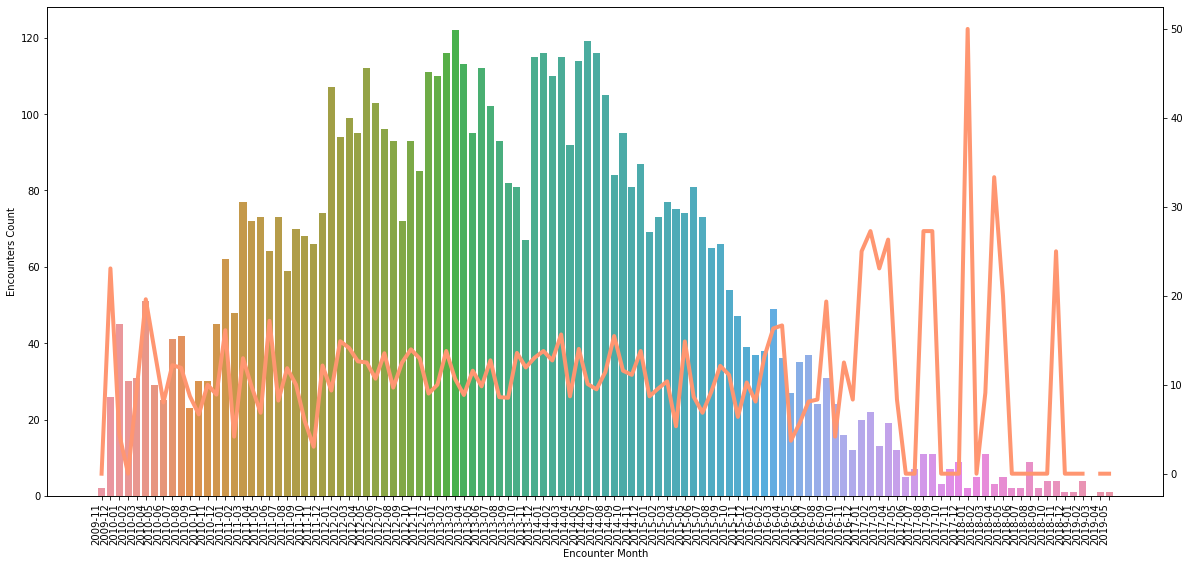

In [159]:
fig, ax1 = plt.subplots(figsize = (20,9))

ax1 = sns.barplot(x = "Encounter Month", 
                  y = "Encounters Count", 
                  data = monthly_u30_rates, 
               #   color = '#0e5d59',
                  saturation = 0.75,
                  estimator = sum, 
                  ci = None, 
                  ax=ax1)

ax2 = ax1.twinx()

ax2.plot(ax1.get_xticks(), 
         monthly_u30_rates['Under 30 Days Rate'],
         color = '#ff9671',
         linewidth = 4)


x_dates = monthly_u30_rates['Encounter Month'].dt.strftime('%Y-%m').sort_values()
ax1.set_xticklabels(labels=x_dates, rotation=90, ha='right')
#ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
#ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))

### 30-day readmissions aggregated over 12 Months

In [186]:
b_encounters = readmissions.groupby(readmissions['Encounter End Date'].dt.month)['Encounter ID'].count().reset_index()
b_readm = readmissions.groupby(readmissions['Encounter End Date'].dt.month)['Under 30 Days'].sum().reset_index()
u30_month_sum = pd.merge(b_encounters, b_readm, how = 'inner')
u30_month_sum.rename(columns = {'Encounter End Date': 'Encounter Month', 'Encounter ID': 'Encounter Count'}, 
                     inplace = True)
u30_month_sum['u30d_rate'] = u30_month_sum['Under 30 Days']*100/u30_month_sum['Encounter Count']

pvl(x = u30_month_sum, nobs = 'Encounter Count', count = 'Under 30 Days', null_hyp = 0.1127)

,Encounter Month,Encounter Count,Under 30 Days,u30d_rate,pval,significant
0,1,569,64,11.247803,0.986641,False
1,2,540,64,11.851852,0.668961,False
2,3,594,78,13.131313,0.151416,False
3,4,557,63,11.310592,0.975832,False
4,5,542,64,11.808118,0.691981,False
5,6,546,56,10.256410,0.453879,False
6,7,547,56,10.237660,0.445155,False
7,8,501,52,10.379242,0.528371,False
8,9,441,55,12.471655,0.424871,False
9,10,452,48,10.619469,0.661850,False


# Problem 2: 7-day PCP Rate

## Merge readmissions and pcp, then clean until at most 1 pcp visit per hospital visit

In [161]:
#merger readmissions with pc
readm_pcp = pd.merge(readmissions, pc, how = 'left', on = 'Patient ID', suffixes = ('', ' PCP'))

#create timedelta column between hospital release and PCP visit (will have negatives)
readm_pcp['Hospital to PCP Days'] = readm_pcp['Encounter Date'] - readm_pcp['Encounter End Date']

#cut out all rows with negative time in Hospital to PCP Days, but keep na rows (people who never saw PCP)
readm_pcp = readm_pcp[(readm_pcp['Hospital to PCP Days'] >= dt.timedelta(days = 0)) | (readm_pcp['Hospital to PCP Days'].isnull())]

#Keep people who never saw PCP and rows where Hospital to PCP Days is minimized by Patient ID and patient_adm_ct
readm_pcp = readm_pcp[readm_pcp['Hospital to PCP Days'].isnull() 
                      | 
                      (readm_pcp['Hospital to PCP Days'] == readm_pcp.groupby(['Patient ID', 'Patient Adm Count'])['Hospital to PCP Days'].transform('min'))]

#create boolean column for PCP visits within 7 days
readm_pcp['PCP Under 7 Days'] = readm_pcp['Hospital to PCP Days'] <= dt.timedelta(days = 7)

# merge to new re_pcp dataframe, fill NAs with False
re_pcp = pd.merge(readmissions, readm_pcp, how = 'left')
re_pcp['PCP Under 7 Days'] = re_pcp['PCP Under 7 Days'].fillna(False)

re_pcp

,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,...,Encounter Start Date Next,Days Until Readmission,Under 30 Days,Encounter ID PCP,Attending Provider NPI PCP,Service Provider NPI,Provider Group NPI,Encounter Date,Hospital to PCP Days,PCP Under 7 Days
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,NaN,NaN,O70.0,First degree perineal laceration during delivery,...,NaT,NaT,False,COV|PCSL|DS1|10033|P|711310|1043427248|1,NaN,1619980406,1043427248,2014-02-16,398 days,False
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,1669599197,1902803315,2014-01-05,2014-01-12,348.4,Compression of brain,NaN,NaN,...,NaT,NaT,False,COV|PBSL|DS1|10043|P|538933|1043427248|1|SHIFTED,NaN,1619199791,1043427248,2014-01-12,0 days,True
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,1407880511,1902803315,2012-06-13,2012-06-21,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,...,NaT,NaT,False,COV|PBSL|DS1|10073|P|301709|1043427248|1|SHIFTED,NaN,1659394021,1043427248,2012-06-27,6 days,True
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,1407008907,1427055839,2012-12-06,2012-12-09,NaN,NaN,O70.1,Second degree perineal laceration during delivery,...,NaT,NaT,False,COV|PCSL|DS1|10101|P|1189971|1043427248|1,NaN,1952538340,1043427248,2012-12-12,3 days,True
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,1518045608,1992818256,2015-03-11,2015-03-14,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",...,NaT,NaT,False,COV|PCSL|DS1|10118|P|486026|1043427248|1,NaN,1316361942,1043427248,2015-11-04,235 days,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,1720043417,1689772592,2015-02-06,2015-02-11,NaN,NaN,O44.13,"Complete placenta previa with hemorrhage, thir...",...,NaT,NaT,False,COV|PCSL|DS1|9979|P|281365|1477666352|1,NaN,1740277995,1477666352,2015-02-15,4 days,True
6210,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,1215968474,1427055839,2014-08-07,2014-08-10,664.11,"Second-degree perineal laceration, delivered, ...",NaN,NaN,...,NaT,NaT,False,COV|PCSL|DS1|9981|P|1094367|1043427248|1,NaN,1992932388,1043427248,2014-08-11,1 days,True
6211,HIA|DS1|9994|DS1|NPI|1689608150|1,DS1|9994,1861831836,1689608150,2015-11-21,2015-11-23,NaN,NaN,O76,Abnormality in fetal heart rate and rhythm com...,...,2015-11-24,1 days,True,COV|PCSL|DS1|9994|P|1238517|1407058787|2,NaN,1487734547,1407058787,2015-12-05,12 days,False
6212,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,1750544516,1689608150,2015-11-24,2015-11-27,NaN,NaN,O42.92,"Full-term premature rupture of membranes, unsp...",...,NaT,NaT,False,COV|PCSL|DS1|9994|P|1238517|1407058787|2,NaN,1487734547,1407058787,2015-12-05,8 days,False


In [162]:
# THIS CODE IS FOR CHECKING AND DATA CLEANING
# print(round(sum(readm_pcp['PCP Under 7 Days'])*100/len(readmissions), 2), '% see PCP within 7 days of hospital release.')
# sum(readm_pcp['PCP Under 7 Days'])

In [163]:
#Note this weird extra row that's been created with the merge back.
#The difference between these two rows: Had two different follow-ups within same day.
#Should only count as one hospital Encounter admission and only as one PCP follow-up
#re_pcp[re_pcp.duplicated(subset='Encounter ID', keep=False)]

In [164]:
#Under 7-days PCP visit rate
hosp_encounter_ct = len(re_pcp['Encounter ID'].unique())
pcp_u7_ct = re_pcp['PCP Under 7 Days'].sum()-re_pcp.duplicated(subset = 'Encounter ID').sum()
pcp_u7_rate = pcp_u7_ct/hosp_encounter_ct
print(round(100*pcp_u7_rate,3), '% of admissions see PCP within 7 days of hospital release.')

30.002 % of admissions see PCP within 7 days of hospital release.


In [165]:
#numerator check
sum(re_pcp['PCP Under 7 Days'])-re_pcp.duplicated(subset = 'Encounter ID').sum()

1864

### Mean Hospital-to-PCP days

In [166]:
re_pcp['Hospital to PCP Days'].mean()

Timedelta('106 days 07:57:22.527339004')

### PCP rates by month

In [167]:
monthly_u7 = re_pcp.groupby(pd.Grouper(key = 'Encounter End Date',freq='M'))['PCP Under 7 Days'].sum()
monthly_u7 = pd.DataFrame({'Encounter Month':monthly_u7.index, 'Under 7 Days Count':monthly_u7.values})


monthly_encounters = readmissions.groupby(pd.Grouper(key = 'Encounter End Date',freq='M'))['Encounter ID'].count()
monthly_encounters = pd.DataFrame({'Encounter Month': monthly_encounters.index, 'Encounters Count': monthly_encounters.values})

monthly_u7_rates = pd.merge(monthly_encounters, monthly_u7, how = 'inner')

monthly_u7_rates['u7d_rate'] = 100*monthly_u7_rates['Under 7 Days Count'] / monthly_u7_rates['Encounters Count']

print(monthly_u7_rates)

    Encounter Month  Encounters Count  Under 7 Days Count    u7d_rate
0        2009-11-30                 2                   0    0.000000
1        2009-12-31                26                   8   30.769231
2        2010-01-31                45                  14   31.111111
3        2010-02-28                30                  13   43.333333
4        2010-03-31                31                   9   29.032258
..              ...               ...                 ...         ...
110      2019-01-31                 1                   1  100.000000
111      2019-02-28                 4                   2   50.000000
112      2019-03-31                 0                   0         NaN
113      2019-04-30                 1                   0    0.000000
114      2019-05-31                 1                   0    0.000000

[115 rows x 4 columns]


[Text(0, 0, '2009-11'),
 Text(1, 0, '2009-12'),
 Text(2, 0, '2010-01'),
 Text(3, 0, '2010-02'),
 Text(4, 0, '2010-03'),
 Text(5, 0, '2010-04'),
 Text(6, 0, '2010-05'),
 Text(7, 0, '2010-06'),
 Text(8, 0, '2010-07'),
 Text(9, 0, '2010-08'),
 Text(10, 0, '2010-09'),
 Text(11, 0, '2010-10'),
 Text(12, 0, '2010-11'),
 Text(13, 0, '2010-12'),
 Text(14, 0, '2011-01'),
 Text(15, 0, '2011-02'),
 Text(16, 0, '2011-03'),
 Text(17, 0, '2011-04'),
 Text(18, 0, '2011-05'),
 Text(19, 0, '2011-06'),
 Text(20, 0, '2011-07'),
 Text(21, 0, '2011-08'),
 Text(22, 0, '2011-09'),
 Text(23, 0, '2011-10'),
 Text(24, 0, '2011-11'),
 Text(25, 0, '2011-12'),
 Text(26, 0, '2012-01'),
 Text(27, 0, '2012-02'),
 Text(28, 0, '2012-03'),
 Text(29, 0, '2012-04'),
 Text(30, 0, '2012-05'),
 Text(31, 0, '2012-06'),
 Text(32, 0, '2012-07'),
 Text(33, 0, '2012-08'),
 Text(34, 0, '2012-09'),
 Text(35, 0, '2012-10'),
 Text(36, 0, '2012-11'),
 Text(37, 0, '2012-12'),
 Text(38, 0, '2013-01'),
 Text(39, 0, '2013-02'),
 Text(40, 

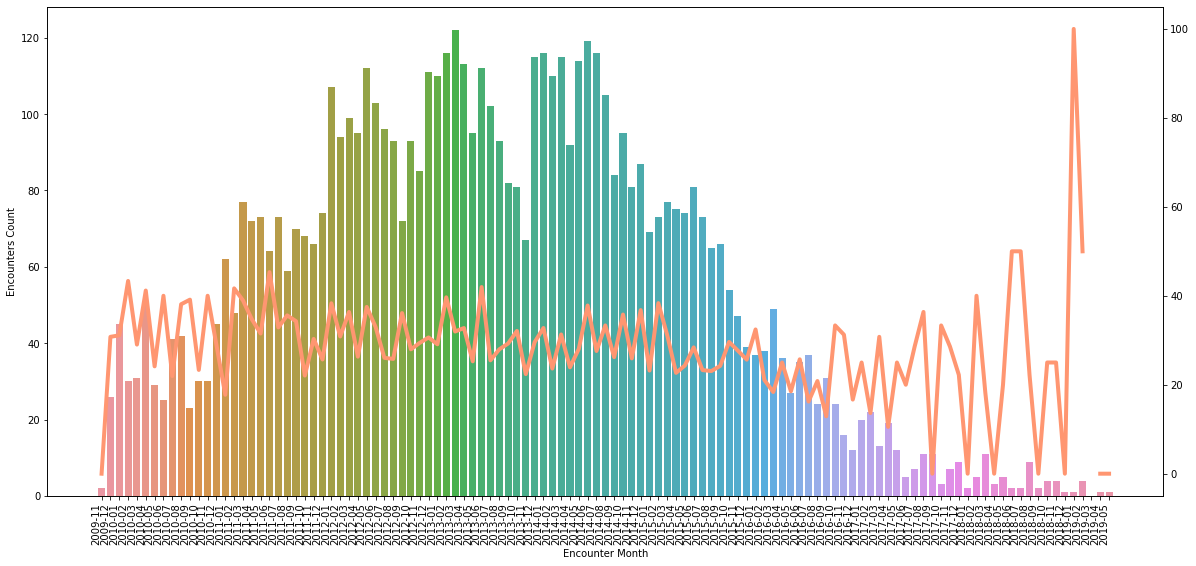

In [168]:
fig, ax1 = plt.subplots(figsize = (20,9))
#p1 = sns.color_palette('twilight', 12)

ax1 = sns.barplot(x = "Encounter Month", 
                  y = "Encounters Count", 
                  data = monthly_u7_rates, 
                  estimator = sum, 
               #   color = '#0e5d59',
                  saturation = 0.75,
               #   palette = p1,
                  ci = None, 
                  ax=ax1)

ax2 = ax1.twinx()

ax2.plot(ax1.get_xticks(), monthly_u7_rates['u7d_rate'], c = '#ff9671', linewidth = 4)


x_dates = monthly_u7_rates['Encounter Month'].dt.strftime('%Y-%m').sort_values()
ax1.set_xticklabels(labels=x_dates, rotation=90, ha='right')
#ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
#ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))

### PCP Aggregated over 12 Months

In [187]:
b_encounters = readmissions.groupby(readmissions['Encounter End Date'].dt.month)['Encounter ID'].count().reset_index()
b_pcp = re_pcp.groupby(re_pcp['Encounter End Date'].dt.month)['PCP Under 7 Days'].sum().reset_index()
u7_month_sum = pd.merge(b_encounters, b_pcp, how = 'inner')
u7_month_sum.rename(columns = {'Encounter End Date': 'Encounter Month', 'Encounter ID': 'Encounter Count'}, 
                     inplace = True)
u7_month_sum['u7d_rate'] = u7_month_sum['PCP Under 7 Days']*100/u7_month_sum['Encounter Count']

pvl(x = u7_month_sum,nobs = 'Encounter Count', count = 'PCP Under 7 Days', null_hyp = pcp_u7_rate)

,Encounter Month,Encounter Count,PCP Under 7 Days,u7d_rate,pval,significant
0,1,569,170,29.876977,0.948274,False
1,2,540,177,32.777778,0.159204,False
2,3,594,189,31.818182,0.333986,False
3,4,557,158,28.366248,0.399665,False
4,5,542,155,28.597786,0.475738,False
5,6,546,199,36.446886,0.001015,True
6,7,547,142,25.959781,0.039132,True
7,8,501,148,29.540918,0.821967,False
8,9,441,125,28.344671,0.447677,False
9,10,452,134,29.646018,0.868968,False


# Problem 3
## Part A: Does 30-day readmission rate vary by hospital?

In [169]:
# For each facility NPI, calculate a sum of readmissions within 30 days
# divided by the number of admissions to that facility NPI
facility_u30_ct = readmissions.groupby('Facility Provider NPI', as_index = False)['Under 30 Days'].sum()
encounters_by_facility = readmissions.groupby('Facility Provider NPI', as_index = False)['Encounter ID'].count()

facility_u30 = pd.merge(encounters_by_facility, facility_u30_ct, how = 'left')

facility_u30['Facility U30 Days Rate'] = 100*facility_u30['Under 30 Days']/facility_u30['Encounter ID']
facility_u30
fac_u30_sum = facility_u30[facility_u30['Encounter ID'] >= 10].sort_values('Facility U30 Days Rate', ascending = False).head(9).reset_index(drop=True)
fac_u30_sum

,Facility Provider NPI,Encounter ID,Under 30 Days,Facility U30 Days Rate
0,1952546616,10,7,70.000000
1,1265814065,11,4,36.363636
2,1336328244,10,3,30.000000
3,1841277704,11,3,27.272727
4,1770532608,11,3,27.272727
5,1639172372,20,4,20.000000
6,1467459776,16,3,18.750000
7,1053351916,11,2,18.181818
8,1811080526,22,4,18.181818


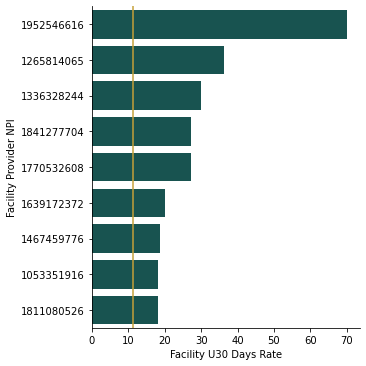

In [170]:
sns.catplot(data = facility_u30[facility_u30['Encounter ID'] >= 10], 
            x = 'Facility U30 Days Rate', 
            y = 'Facility Provider NPI', 
            kind = 'bar',
            color = '#0e5d59',
            order = (facility_u30[facility_u30['Encounter ID'] >= 10].
                     sort_values('Facility U30 Days Rate', ascending = False)['Facility Provider NPI'].
                     head(9))
           )

plt.axvline(11.27, color = '#c6a139')

## Part B: Does 30-day readmission rate vary by hospital physician?

In [171]:
att_u30_ct = readmissions.groupby('Attending Provider NPI', as_index = False)['Under 30 Days'].sum()
encounters_by_att = readmissions.groupby('Attending Provider NPI', as_index = False)['Encounter ID'].count()

att_u30 = pd.merge(encounters_by_att, att_u30_ct, how = 'left')

att_u30['Attending Provider U30 Days Rate'] = 100*att_u30['Under 30 Days']/att_u30['Encounter ID']
att_u30
att_u30_sum = att_u30[att_u30['Encounter ID'] >= 10].sort_values('Attending Provider U30 Days Rate', ascending = False).head(10)
att_u30_sum

,Attending Provider NPI,Encounter ID,Under 30 Days,Attending Provider U30 Days Rate
1130,1568574937,12,4,33.333333
497,1245477652,11,3,27.272727
1794,1932230810,12,3,25.000000
1332,1679541775,34,8,23.529412
814,1417061797,39,8,20.512821
471,1235174103,10,2,20.000000
20,1013113679,10,2,20.000000
112,1053358127,25,5,20.000000
574,1295768638,16,3,18.750000
162,1073566931,22,4,18.181818


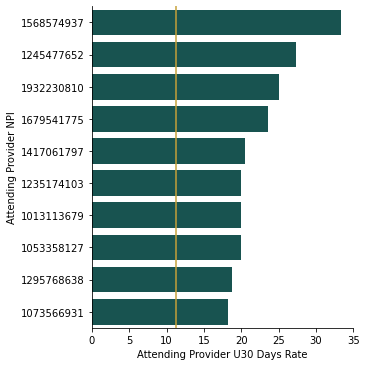

In [172]:
sns.catplot(data = att_u30_sum, 
            x = 'Attending Provider U30 Days Rate', 
            y = 'Attending Provider NPI', 
            kind = 'bar',
            color = '#0e5d59',
            order = (att_u30_sum.
                     sort_values('Attending Provider U30 Days Rate', ascending = False)['Attending Provider NPI'].
                     head(10))
           )
plt.axvline(11.27, color = '#c6a139')

## Part C: Does 7-day follow-up rate vary by group PCP?

In [173]:
pcp_u7_by_group = re_pcp.groupby('Provider Group NPI', as_index = False)['PCP Under 7 Days'].sum()
encounters_by_pcp_group = re_pcp.groupby('Provider Group NPI', as_index = False)['Encounter ID'].count()

pcp_group_u7 = pd.merge(encounters_by_pcp_group, pcp_u7_by_group, how = 'left')

pcp_group_u7['PCP Group U7 Days Rate'] = 100*pcp_group_u7['PCP Under 7 Days']/pcp_group_u7['Encounter ID']
pcp_group_u7
pcp_group_u7[pcp_group_u7['Encounter ID'] >= 10].sort_values("PCP Group U7 Days Rate", ascending = False).head(50)

,Provider Group NPI,Encounter ID,PCP Under 7 Days,PCP Group U7 Days Rate
95,1245579655,11,10,90.909091
92,1235187311,19,13,68.421053
146,1386637346,15,9,60.000000
70,1164512851,481,212,44.074844
200,1518947167,19,8,42.105263
82,1205884392,31,13,41.935484
33,1083694616,17,7,41.176471
347,1912987553,108,44,40.740741
59,1144213166,25,10,40.000000
20,1043427248,2209,842,38.116795


## Part D: Does 7-day follow-up rate vary by PCP physician?

In [174]:
pcp_u7_by_provider = re_pcp.groupby('Service Provider NPI', as_index = False)['PCP Under 7 Days'].sum()
encounters_by_pcp_provider = re_pcp.groupby('Service Provider NPI', as_index = False)['Encounter ID'].count()

pcp_provider_u7 = pd.merge(encounters_by_pcp_provider, pcp_u7_by_provider, how = 'left')

pcp_provider_u7['PCP Provider U7 Days Rate'] = 100*pcp_provider_u7['PCP Under 7 Days']/pcp_provider_u7['Encounter ID']
pcp_provider_u7.sort_values("Encounter ID", ascending = False)

,Service Provider NPI,Encounter ID,PCP Under 7 Days,PCP Provider U7 Days Rate
277,1104884337,66,41,62.121212
1876,1619980406,52,18,34.615385
3012,1972704856,50,12,24.000000
1391,1467643700,50,28,56.000000
1276,1437180965,49,28,57.142857
...,...,...,...,...
1630,1538495973,0,0,NaN
1629,1538484084,0,0,NaN
1628,1538480686,0,0,NaN
1627,1538435417,0,0,NaN


## Bonus: Readmissions Data Analyzed by Members

In [175]:
#df merge: members and readmissions
remembpcp = pd.merge(re_pcp, memb, how = 'left', on = 'Patient ID')
remembpcp

,Encounter ID,Patient ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,...,Hospital to PCP Days,PCP Under 7 Days,Primary Plan ID,Patient Age Integer,Patient Date of Birth,Patient ZIP Code 5-Digit,Empirically Attributed PCP Individual Provider NPI,Empirically Attributed PCP Individual Provider Description,Empirically Attributed PCP Group Provider NPI,Empirically Attributed PCP Group Provider Description
0,HIA|DS1|10033|DS1|NPI|1306890389|1,DS1|10033,1417170523,1306890389,2013-01-12,2013-01-14,NaN,NaN,O70.0,First degree perineal laceration during delivery,...,398 days,False,DS1|5047X,1,2012-11-09,94123.0,1225216351.0,"CLIMACO, ANNE MAE B.",1043427248.0,UCLA MEDICAL GROUP
1,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,1669599197,1902803315,2014-01-05,2014-01-12,348.4,Compression of brain,NaN,NaN,...,0 days,True,DS1|5047Y,34,1979-12-28,90307.0,1619199791.0,"CANALE, STEPHANIE .",1043427248.0,UCLA MEDICAL GROUP
2,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,1407880511,1902803315,2012-06-13,2012-06-21,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,...,6 days,True,DS1|5047X,64,1946-01-07,92122.0,NaN,NaN,NaN,NaN
3,HIA|DS1|10101|DS1|NPI|1427055839|1,DS1|10101,1407008907,1427055839,2012-12-06,2012-12-09,NaN,NaN,O70.1,Second degree perineal laceration during delivery,...,3 days,True,DS1|5047W,11,2003-01-25,90278.0,1801189048.0,"KO, ELIZABETH .",1043427248.0,UCLA MEDICAL GROUP
4,HIA|DS1|10118|DS1|NPI|1992818256|1,DS1|10118,1518045608,1992818256,2015-03-11,2015-03-14,NaN,NaN,F32.9,"Major depressive disorder, single episode, uns...",...,235 days,False,DS1|5047W,1,2012-08-12,94118.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6209,HIA|DS1|9979|DS1|NPI|1689772592|1,DS1|9979,1720043417,1689772592,2015-02-06,2015-02-11,NaN,NaN,O44.13,"Complete placenta previa with hemorrhage, thir...",...,4 days,True,DS1|5047X,39,1979-10-19,94404.0,NaN,NaN,NaN,NaN
6210,HIA|DS1|9981|DS1|NPI|1427055839|1,DS1|9981,1215968474,1427055839,2014-08-07,2014-08-10,664.11,"Second-degree perineal laceration, delivered, ...",NaN,NaN,...,1 days,True,DS1|5047W,33,1981-03-01,94116.0,NaN,NaN,NaN,NaN
6211,HIA|DS1|9994|DS1|NPI|1689608150|1,DS1|9994,1861831836,1689608150,2015-11-21,2015-11-23,NaN,NaN,O76,Abnormality in fetal heart rate and rhythm com...,...,12 days,False,DS1|5047W,37,1976-04-07,92126.0,1669552832.0,"NGUYEN, LAN T.",1205884392.0,UCI DEPARTMENT OF MEDICINE
6212,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,1750544516,1689608150,2015-11-24,2015-11-27,NaN,NaN,O42.92,"Full-term premature rupture of membranes, unsp...",...,8 days,False,DS1|5047W,37,1976-04-07,92126.0,1669552832.0,"NGUYEN, LAN T.",1205884392.0,UCI DEPARTMENT OF MEDICINE


# Addenda: NOTHING AFTER THIS IS FOR PROJECT USE

## Problem 1: Method 2: for-loop over iterrows()

In [176]:
days_till_readmission = []
for index, row in adm.iterrows():
    if row['Patient Adm Count'] == 1:
        readm_time = pd.to_datetime(None)
    else:
        readm_time = (row['Encounter Start Date'] - adm[(adm['Patient ID'] == row['Patient ID'])
                                &
                                (adm['Patient Adm Count'] == row['Patient Adm Count']-1)]['Encounter End Date']).dt.days.values[0]
    days_till_readmission.append(readm_time)
    
days_till_readmission    
# admissions['days_till_readmission'] = days_till_readmission
# admissions['days_till_readmission'] = admissions['days_till_readmission'].dt.days
# print(admissions['days_till_readmission'])

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 135,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 496,
 47,
 None,
 None,
 285,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 126,
 None,
 31,
 0,
 5,
 47,
 25,
 28,
 73,
 27,
 27,
 4,
 None,
 None,
 None,
 None,
 None,
 None,
 4,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 0,
 None,
 None,
 674,
 None,
 78,
 -19,
 -2,
 17,
 None,
 None,
 None,
 None,
 151,
 19,
 222,
 0,
 None,
 None,
 116,
 95,
 105,
 None,
 None,
 None,
 111,
 125,
 None,
 None,
 None,
 0,
 None,
 None,
 None,
 None,
 301,
 None,
 None,
 None,
 47,
 None,
 None,
 None,
 None,
 139,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 590,
 None,
 None,
 None,
 364,
 1,
 None,
 70,
 157,
 38,
 47,
 6,
 None,
 647,
 None,
 None,
 None,
 None,
 None,
 None,
 10,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 No

## Checking My Work

In [180]:
#Checking for number of encounters picked up by each aggregation in Problem 3 (Note difference from 6213)
print(facility_u30['Encounter ID'].sum())
print(att_u30['Encounter ID'].sum())
print(pcp_group_u7['Encounter ID'].sum())
print(pcp_provider_u7['Encounter ID'].sum())

6213
5884
4840
4926


## Timeplots Gone Wrong

### Basic Readmissions timeplot without bars

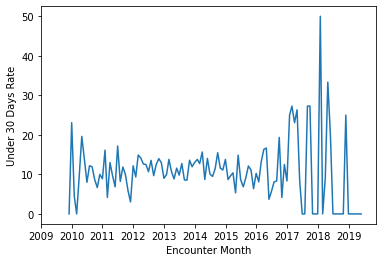

In [181]:
g = sns.lineplot(x = 'Encounter Month', y = 'Under 30 Days Rate', data = monthly_u30_rates)
g.set(xlim = (pd.to_datetime('2008-12-31'),None))
plt.savefig('monthly_u30_rates_rough', transparent = True)

### Plots split out (bar in the 1970s)

(array([-3653.,     0.,  3652.,  7305., 10957., 14610., 18262., 21915.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

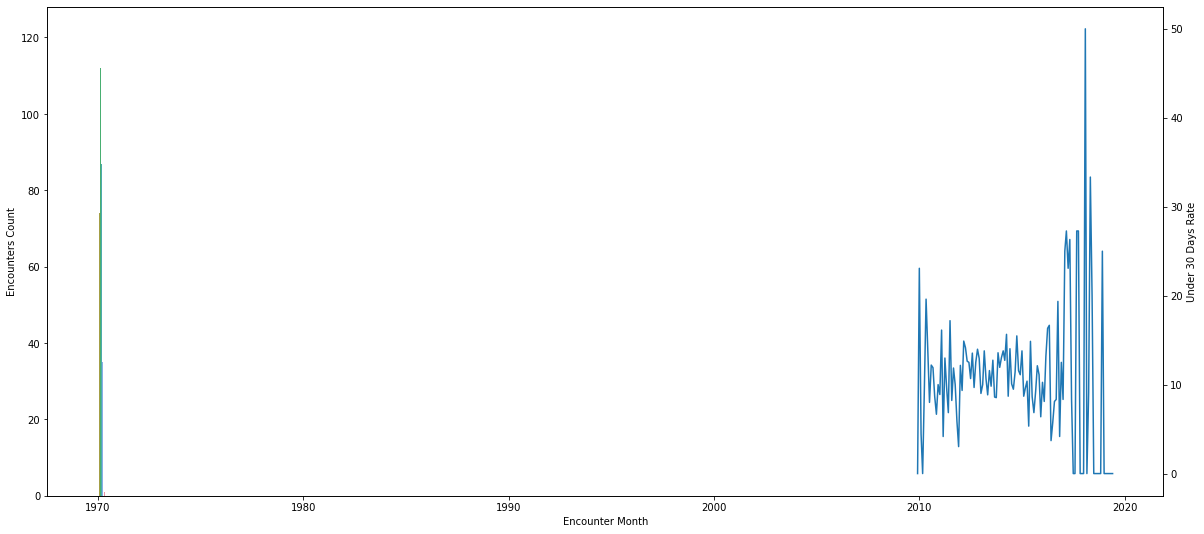

In [182]:
fig, ax1 = plt.subplots(figsize = (20,9))
ax2 = ax1.twinx()

sns.barplot(data = monthly_u30_rates, x = 'Encounter Month', y = 'Encounters Count', ax = ax1, order = monthly_u30_rates['Encounter Month'])
sns.lineplot(data = monthly_u30_rates, x = 'Encounter Month', y = 'Under 30 Days Rate', ax = ax2)

#ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
#ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b - %y'))
plt.xticks(rotation = 90)

### xticks in the 1970s, no interval customization

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

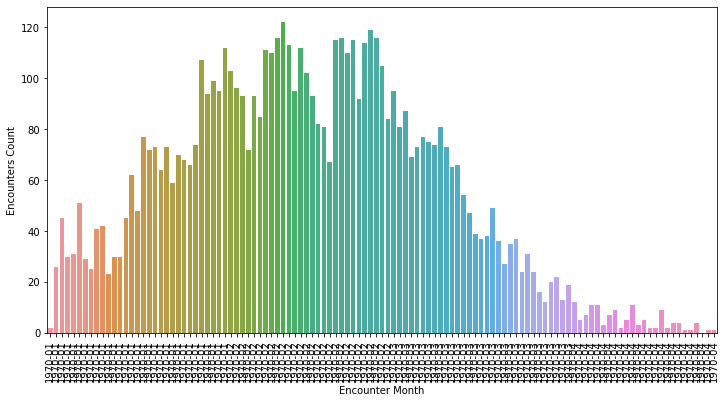

In [183]:
fig, ax1 = plt.subplots(figsize = (12,6))  
#monthly_u30_rates['Encounter Month'] = pd.to_datetime(monthly_u30_rates['Encounter Month'], format = '%Y-%m')
fig = sns.barplot(x = pd.to_datetime(monthly_u30_rates["Encounter Month"], format = '%Y-%m'), y = "Encounters Count", data = monthly_u30_rates, 
                  estimator = sum, ci = None, ax=ax1)


# specify the position of the major ticks at the beginning of the week
#ax1.xaxis.set_major_locator(mdates.MonthLocator(interval = 3))
# specify the format of the labels as 'year-month-day'
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# (optional) rotate by 90° the labels in order to improve their spacing
plt.setp(ax1.xaxis.get_majorticklabels(), rotation = 90)

# specify the position of the minor ticks at each day
#ax1.xaxis.set_minor_locator(mdates.MonthLocator(interval = 1))